In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from alpha_vantage.foreignexchange import ForeignExchange 

In [2]:
api_key = "968U93YONJTBSCFS"   #My Api Key

In [3]:
# Initialize the ForeignExchange class
fx = ForeignExchange(key= "api_key", output_format="pandas")

In [4]:
# Get the daily exchange rates
data, meta_data = fx.get_currency_exchange_daily(from_symbol="USD", to_symbol="KES", outputsize="full")

In [5]:
# Renaming columns
data.rename(columns={
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close"
}, inplace=True)

In [6]:
data.head()

,Open,High,Low,Close
date,,,,
2024-08-14,128.48000,128.73000,128.23,128.48
2024-08-12,128.00000,128.01000,127.75,128.00
2024-08-11,128.64731,128.65439,127.75,128.25
2024-08-08,128.50000,129.14000,128.00,128.50
2024-08-07,128.00000,128.88001,127.75,128.00


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2608 entries, 2024-08-14 to 2014-08-13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2608 non-null   float64
 1   High    2608 non-null   float64
 2   Low     2608 non-null   float64
 3   Close   2608 non-null   float64
dtypes: float64(4)
memory usage: 101.9 KB


In [8]:
# Summary statistics
data.describe()

,Open,High,Low,Close
count,2608.000000,2608.000000,2608.000000,2608.000000
mean,108.708283,109.374636,108.166127,108.761523
std,15.211774,15.123697,15.268884,15.203563
min,86.615000,86.889000,16.150000,86.602000
25%,99.835500,100.580000,99.349075,99.800000
50%,102.005000,102.860000,101.477500,102.000000
75%,112.650000,113.250000,112.550000,113.062500
max,162.990000,163.210010,161.570010,163.000000


In [9]:
data = data["Close"]
data = pd.DataFrame(data=data)

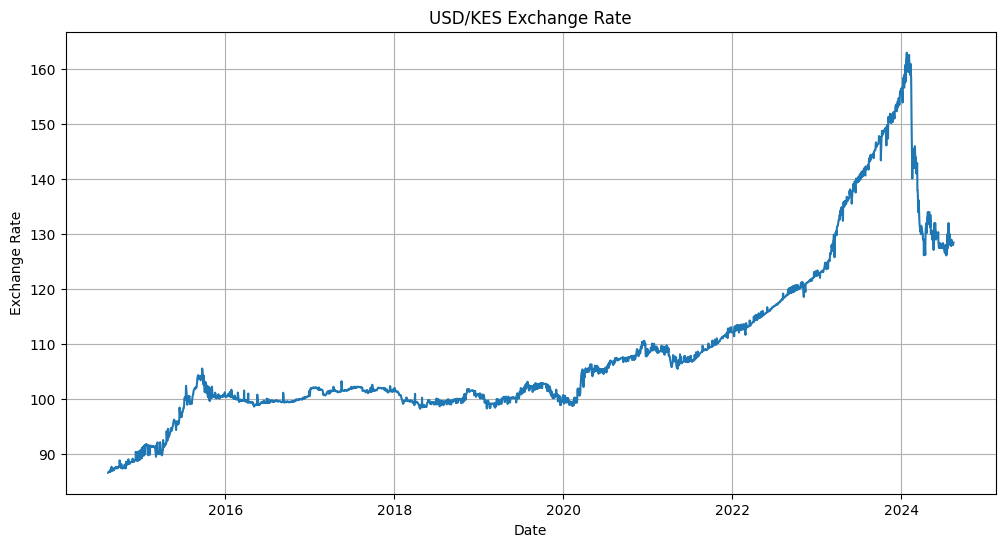

In [10]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [11]:
# Resample the data to include all the days
daily_data = data.resample('D').last()

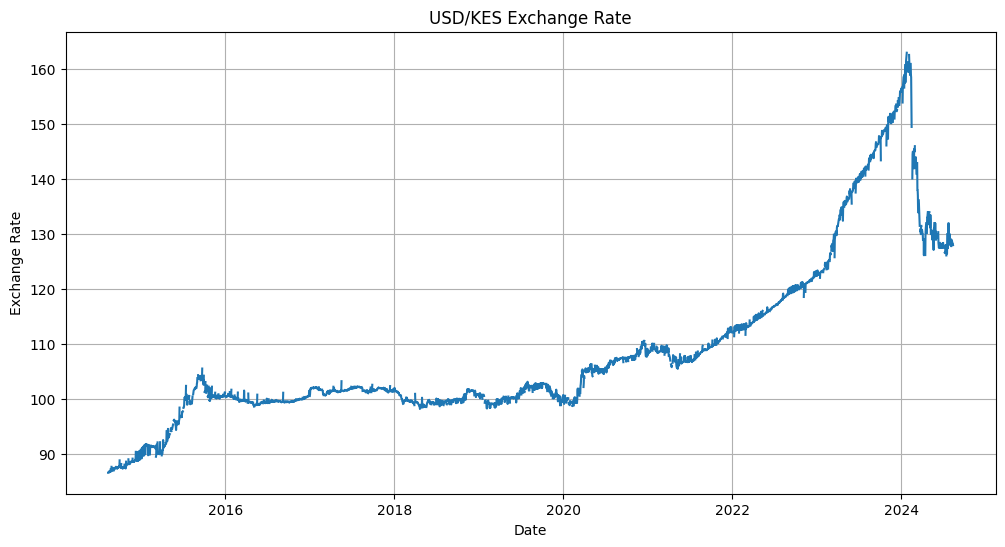

In [12]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Close'])
plt.title('USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid()
plt.show()

In [13]:
# interpolate the data to include weekends
filled_data = daily_data.interpolate(method='linear')

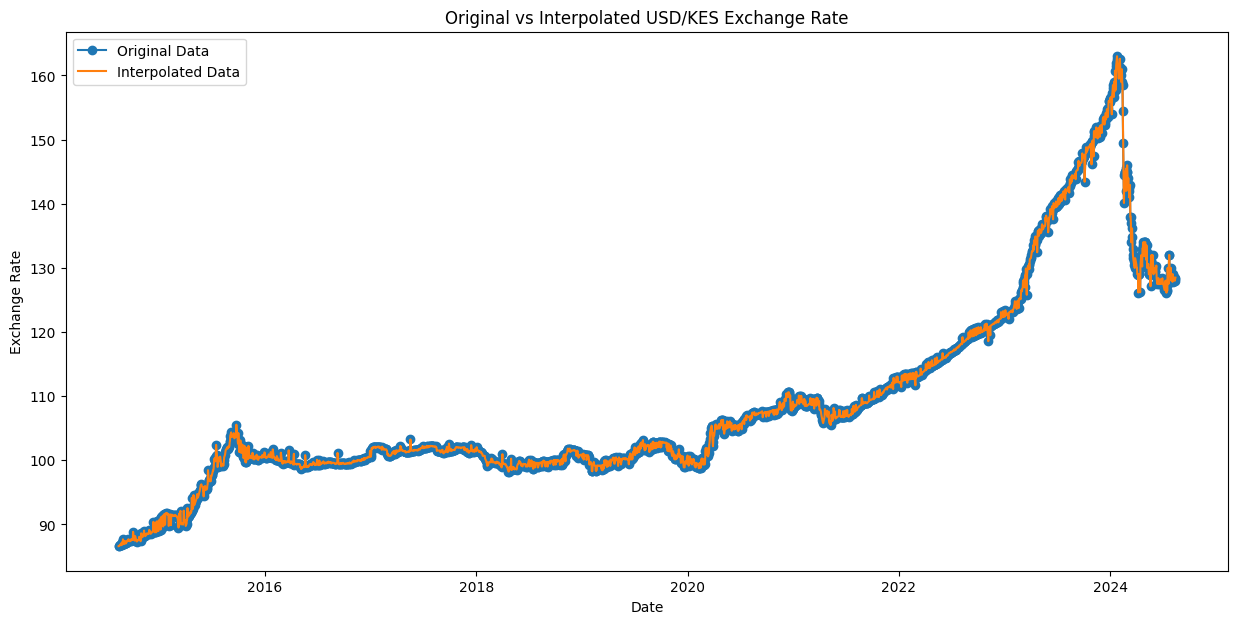

In [14]:
# Plot original vs filled data
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['Close'], label='Original Data', marker='o')
plt.plot(filled_data.index, filled_data['Close'], label='Interpolated Data')
plt.title('Original vs Interpolated USD/KES Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Stationarity Check

In [15]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(filled_data['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# If p-value > 0.05, the series is non-stationary
if adf_test[1] > 0.05:
    print("The series is non-stationary, differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -1.3113025091308046
p-value: 0.6239856690170178
The series is non-stationary, differencing is required.


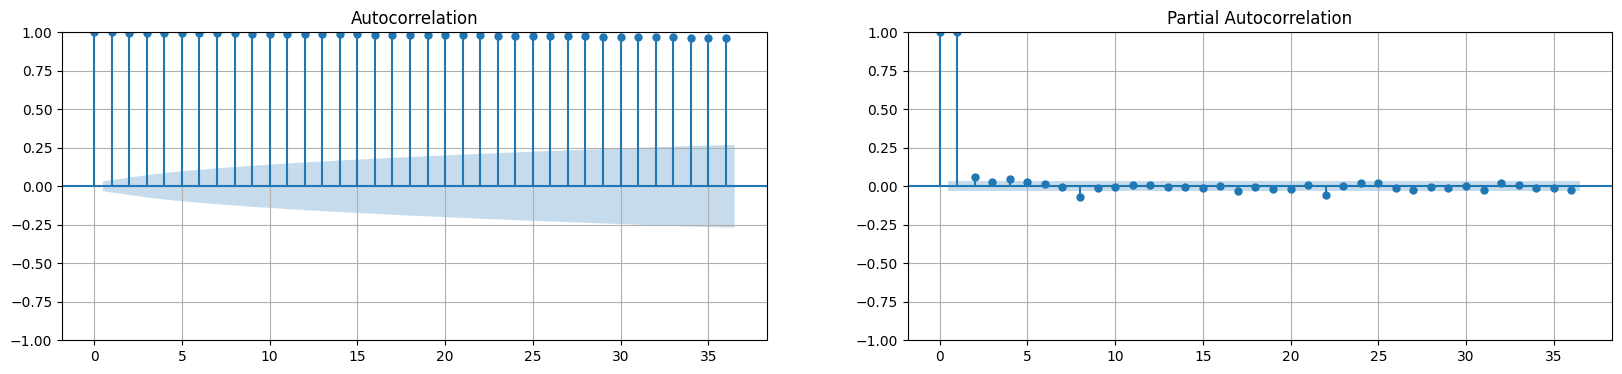

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(filled_data, ax=axes[0])
axes[0].grid(True)
plot_pacf(filled_data, ax=axes[1])
axes[1].grid(True)
plt.show()

ACF is not deminishing

#  Prepare data for modeling

## Split the filled data into train and test sets

In [17]:
# Split the filled data into train and test sets
train_size = int(len(filled_data) * 0.80)
train, test = filled_data[:train_size], filled_data[train_size:]

In [18]:
print("Train: ",train.shape)
print("Test : ",test.shape)

Train:  (2924, 1)
Test :  (731, 1)


## Decomposition

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [20]:
add_decomp = seasonal_decompose(train, model="additive")

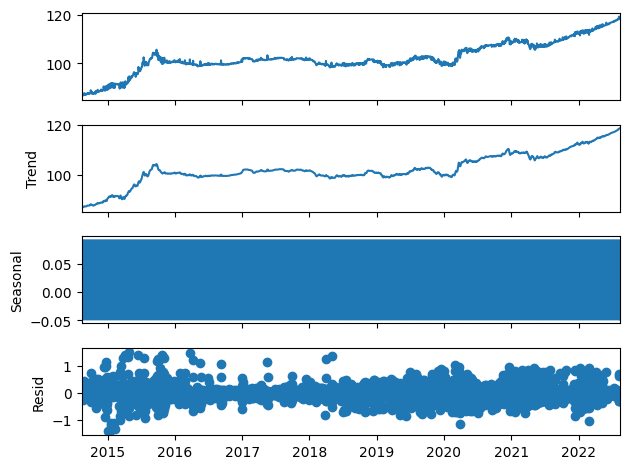

In [21]:
add_decomp.plot()
plt.show()

- there is a trend in the data
- the data is also seasonal
- there is also White noise

## Augmented Dickey-Fuller (ADF) test 

In [22]:
import statsmodels.tsa.stattools as sts
adf_results = sts.adfuller(train)
#adf_results

In [23]:
adf_statistic = adf_results[0]
p_value = adf_results[1]
usedlag = adf_results[2]
nobs = adf_results[3]
critical_values = adf_results[4]
icbest = adf_results[5]

In [24]:
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Number of Lags Used:', usedlag)
print('Number of Observations Used:', nobs)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'\t{key}: {value}')

ADF Statistic: -0.694600290696134
p-value: 0.8481432308947868
Number of Lags Used: 28
Number of Observations Used: 2895
Critical Values:
	1%: -3.4326108316927817
	5%: -2.862538883350276
	10%: -2.567301734125599


Based on the ADF test results, 

- Test statistic: The ADF statistic is -0.694600290696134, which is higher (less negative) than all the critical values.
- p-value: The p-value is 0.8481432308947868, which is greater than the common significance levels (0.01, 0.05, and 0.10).
- Stationarity: Given that the test statistic is higher than the critical values and the p-value is greater than 0.05, we fail to reject the null hypothesis of a unit root. This suggests that the time series is likely non-stationary.
- Critical values: Since the test statistic is less negative than all these critical values, it supporting the conclusion of non-stationarity.
- Sample size: The test is 2,895 observations, which is a relatively large sample size, lending reliability to the results.
- Lag selection: 28 lags were used in the test, which helps account for potential autocorrelation in the residuals.

In conclusion, this time series appears to be non-stationary based on the ADF test results. Further differencing or transformation is necessary to achieve stationarity before proceeding with certain time series analyses or models.

# Modeling


## Differencing the Series

In [25]:
diff = train.diff().dropna()

In [26]:
test_diff = test.diff().dropna()

In [27]:
# diff

In [28]:
# test_diff

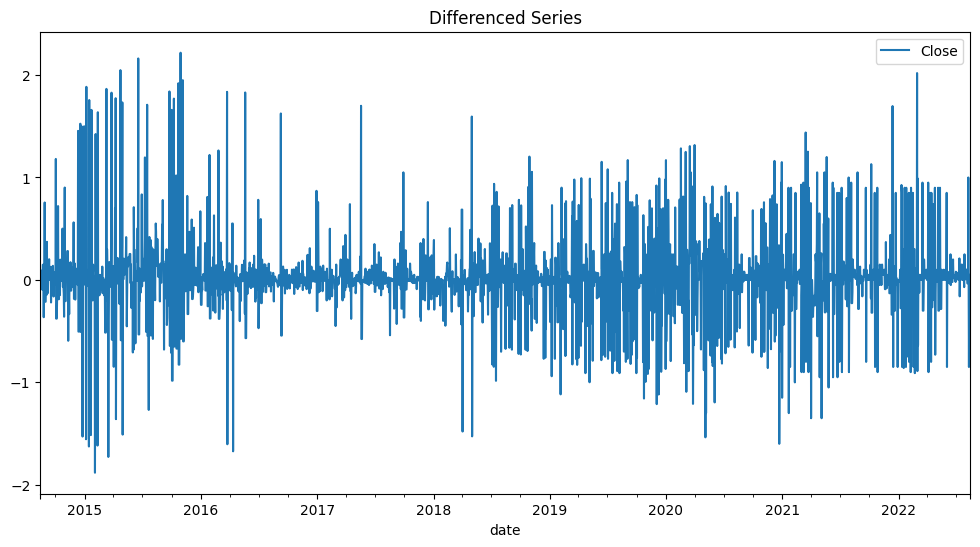

In [29]:
# Plot the differenced series
diff.plot(figsize=(12, 6))
plt.title('Differenced Series')
plt.show()

In [30]:
# Perform the ADF test on the differenced series
adf_result_diff = adfuller(diff)
print('ADF Statistic after Differencing:', adf_result_diff[0])
print('p-value after Differencing:', adf_result_diff[1])
print('Number of Lags Used:', adf_result_diff[2])
print('Number of Observations Used:', adf_result_diff[3])
print('Critical Values after Differencing:', adf_result_diff[4])

ADF Statistic after Differencing: -8.730792363985499
p-value after Differencing: 3.1958365791326374e-14
Number of Lags Used: 28
Number of Observations Used: 2894
Critical Values after Differencing: {'1%': -3.432611613600796, '5%': -2.862539228682693, '10%': -2.5673019179781917}


Deductions
- Since the p-value is now lower than 0.005 and the ADF statistic is more negative than the critical values indicate that the time series has become stationary after differencing. 
- Applying one difference (d=1) was sufficient to make the series stationary.

## Proceeding to identify the appropriate values for p and q by analyzing the ACF and PACF plots.

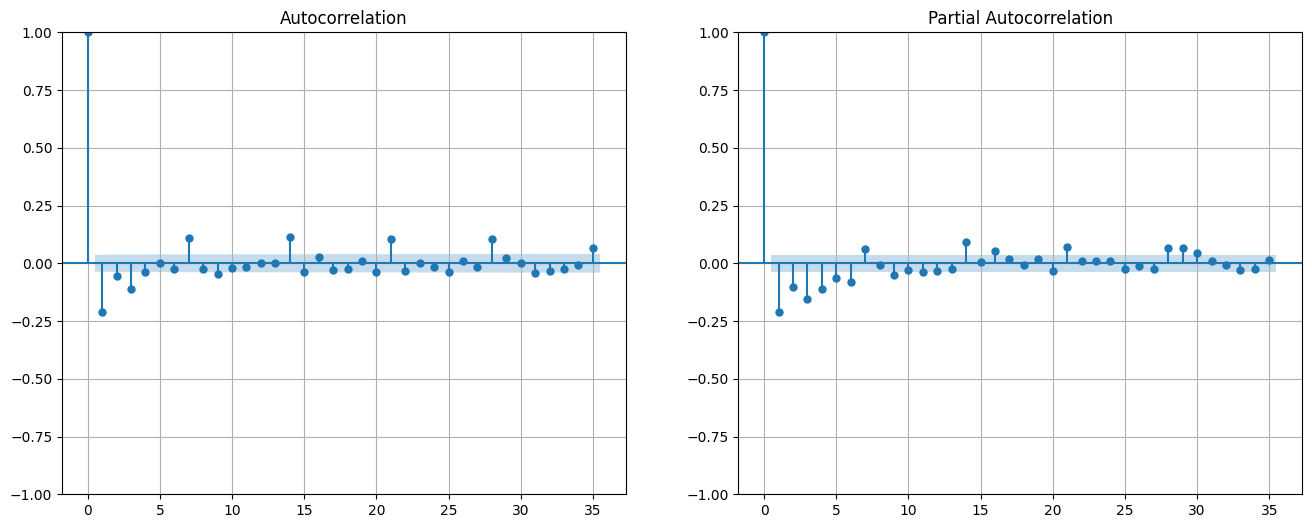

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(diff, ax=axes[0])
axes[0].grid(True)
plot_pacf(diff, ax=axes[1])
axes[1].grid(True)
plt.show()

- p = 1
- d = 1
- q = 1
- m = 7

# Model selection

# Method 1

## 1. ARIMA

In [32]:
from statsmodels.tsa.arima.model import ARIMA

# Replace p, d, q with the values identified from ACF and PACF
model = ARIMA(diff, order=(1, 1, 1))
model_fit = model.fit()

In [33]:
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2923
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1298.060
Date:                Wed, 14 Aug 2024   AIC                           2602.120
Time:                        17:23:18   BIC                           2620.060
Sample:                    08-14-2014   HQIC                          2608.582
                         - 08-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2094      0.013    -15.950      0.000      -0.235      -0.184
ma.L1         -1.0000      0.047    -21.059      0.000      -1.093      -0.907
sigma2         0.1420      0.007     20.136      0.0

In [34]:
predictions = model_fit.predict(start=len(diff), end=len(diff)+ len(test_diff)-1, dynamic=True)

In [35]:
predictions

2022-08-15    0.009691
2022-08-16    0.011151
2022-08-17    0.010846
2022-08-18    0.010910
2022-08-19    0.010896
                ...   
2024-08-09    0.010899
2024-08-10    0.010899
2024-08-11    0.010899
2024-08-12    0.010899
2024-08-13    0.010899
Freq: D, Name: predicted_mean, Length: 730, dtype: float64

In [36]:
from sklearn.metrics import mean_squared_error

# Calculate Mean Squared Error
mse = mean_squared_error(test_diff, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.8030239217232384


## 2. SARIMA


In [37]:
p, d, q = 1, 1, 1

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_s = SARIMAX(diff, order=(p, d, q), seasonal_order=(p, d, q, 7))  
fitted = model_s.fit() 


In [39]:
print(fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 2923
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1246.547
Date:                           Wed, 14 Aug 2024   AIC                           2503.094
Time:                                   17:23:33   BIC                           2532.982
Sample:                               08-14-2014   HQIC                          2513.860
                                    - 08-14-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2216      0.013    -17.107      0.000      -0.247      -0.196
ma.L1         -0.9996      0.004   -231.747

In [40]:
from sklearn.metrics import mean_squared_error

# Get the predicted values
predictions2 = fitted.predict(start=len(diff), end=len(diff)+ len(test_diff)-1, dynamic=True)


In [41]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_diff, predictions2)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.8154063770092287


In [42]:
predictions2

2022-08-15    0.213756
2022-08-16    0.013889
2022-08-17   -0.012085
2022-08-18    0.076756
2022-08-19   -0.040850
                ...   
2024-08-09   -0.041307
2024-08-10   -0.041306
2024-08-11   -0.041306
2024-08-12    0.194059
2024-08-13    0.009060
Freq: D, Name: predicted_mean, Length: 730, dtype: float64

## 3. LSTM Model

# Method2

## 1. ARIMA Model

In [43]:
# Function to calculate RMSE
def calculate_rmse(train, predicted):
    return sqrt(mean_squared_error(train, predicted))

In [44]:
# Step 4: ARIMA Model
def fit_arima(train, test):
    model = ARIMA(train, order=(1, 1, 1))
    results = model.fit()
    
    forecast = results.forecast(steps=len(test))
    rmse = calculate_rmse(test['Close'], forecast)
    
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title('ARIMA Forecast')
    plt.legend()
    plt.show()
    
    print(f'ARIMA RMSE: {rmse}')

Running ARIMA model...


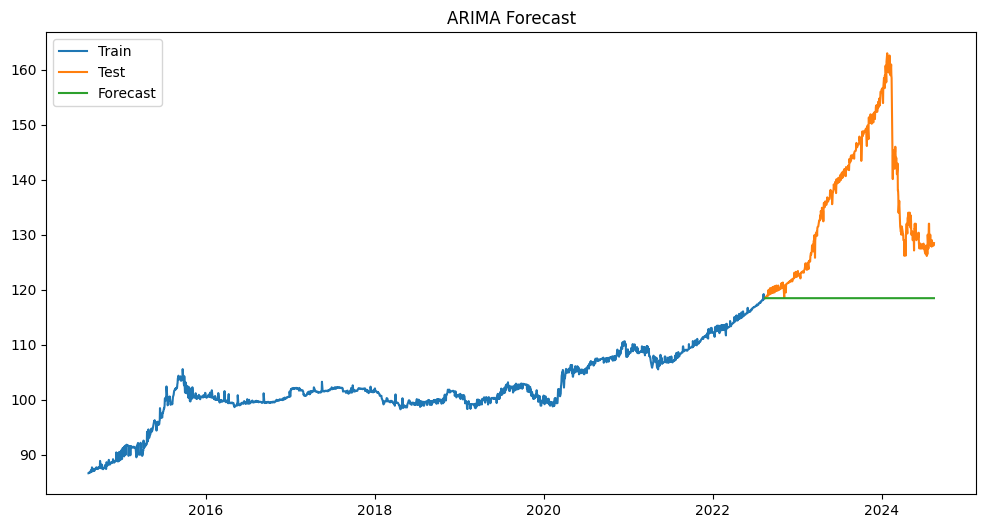

ARIMA RMSE: 20.2927707737032


In [45]:
# Step 7: Run the models
print("Running ARIMA model...")
fit_arima(train, test)

## 2. SARIMA Model

In [46]:

# Step 5: SARIMA Model
def fit_sarima(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    results = model.fit()
    
    forecast = results.forecast(steps=len(test))
    rmse = calculate_rmse(test, forecast)
    
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title('SARIMA Forecast')
    plt.legend()
    plt.show()
    
    print(f'SARIMA RMSE: {rmse}')

Running SARIMA model...


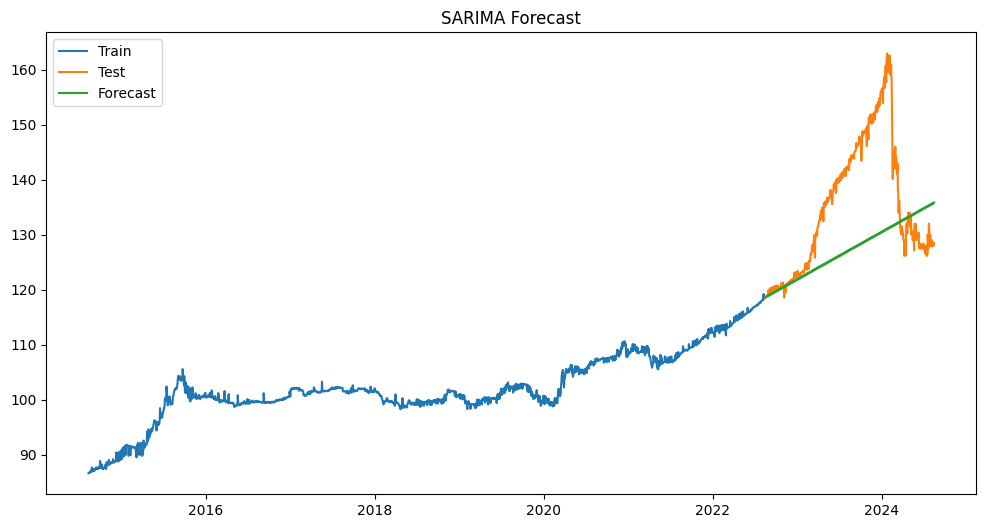

SARIMA RMSE: 12.960068280930932


In [47]:
print("Running SARIMA model...")
fit_sarima(train, test)

## 3. LSTM